# Fake News Dataset Analysis: Understanding Linguistic Patterns for Transformer Model Comparison

## Introduction

This notebook documents the detailed analysis of linguistic patterns that distinguish real from fake news in the ISOT dataset. This analysis is crucial for understanding how different transformer models learn to detect deceptive content and for evaluating their effectiveness at capturing linguistic and stylistic differences. By identifying these patterns, we can better interpret model performance and provide context for comparing lightweight pretrained models like DistilBERT, TinyBERT, MobileBERT, and RoBERTa on fake news detection tasks.

## 1. Setup and Data Loading

### Library Imports

First, I import the necessary libraries for data manipulation, visualization, and text analysis:

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/amid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/amid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


I've selected these libraries for the following reasons:
- `pandas` and `numpy` for efficient data manipulation and numerical operations
- `matplotlib` and `seaborn` for creating informative visualizations
- `re` for regular expression pattern matching in text analysis
- `Counter` for frequency analysis of words and patterns
- `WordCloud` for visualizing common terms in an intuitive way
- `CountVectorizer` and `TfidfVectorizer` for text feature extraction
- `nltk` for natural language processing tasks like tokenization and stopword removal
- `sklearn.model_selection` for data splitting utilities

In [2]:
# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

I configure visualization settings to ensure clear and readable plots, and set pandas display options to show more comprehensive information during analysis.

### Loading the Dataset

Now I load the datasets, checking first for previously cleaned versions:

In [3]:
# Load the datasets
try:
    # Try to load datasets with basic cleaning already applied
    true_news = pd.read_csv('./datasets/true_news_basic_cleaned.csv')
    fake_news = pd.read_csv('./datasets/fake_news_basic_cleaned.csv')
    print("Loaded previously cleaned datasets")
except:
    # If not available, load raw data
    print("Loading raw datasets")
    true_news = pd.read_csv('../data/ISOT/True.csv')
    fake_news = pd.read_csv('../data/ISOT/Fake.csv')
    
    # Add labels
    true_news['label'] = 'Real'
    fake_news['label'] = 'Fake'

Loaded previously cleaned datasets


This approach is efficient because:
1. It attempts to use previously cleaned data if available, saving processing time
2. It falls back to loading raw data if needed
3. It ensures consistent labeling of the data for analysis

## 2. Critical Dataset Bias Identification

Before proceeding with linguistic analysis, I investigate potential biases in the dataset that could affect model training:

In [4]:
# Check for Reuters pattern in true news
reuters_count = true_news['text'].str.contains('\(Reuters\)').sum()
print(f"Number of true news articles containing '(Reuters)': {reuters_count}")
print(f"Percentage: {reuters_count / len(true_news) * 100:.2f}%")

Number of true news articles containing '(Reuters)': 21247
Percentage: 99.21%


In [5]:
# Check if fake news contains this pattern
fake_reuters_count = fake_news['text'].str.contains('\(Reuters\)').sum()
print(f"Number of fake news articles containing '(Reuters)': {fake_reuters_count}")
print(f"Percentage: {fake_reuters_count / len(fake_news) * 100:.2f}%")

Number of fake news articles containing '(Reuters)': 9
Percentage: 0.04%


This analysis reveals a critical finding: 99.21% of true news articles contain the "(Reuters)" pattern, while only 0.04% of fake news articles do. This pattern creates a significant bias that would allow models to "cheat" by using this marker rather than learning substantive differences between real and fake news content.

This finding is crucial for our comparative evaluation of transformer models because:
1. Models might learn to rely on this simple pattern rather than deeper linguistic features
2. This would lead to poor generalization when applied to news from other sources
3. It would make model comparison less meaningful, as all models might simply learn this shortcut

For a fair comparison of transformer models on this dataset, we need to remove these dataset-specific markers.

## 3. Enhanced Data Cleaning

Based on the identified biases, I implement an enhanced cleaning function:

In [6]:
# Enhanced cleaning function
def enhanced_clean_text(text, is_true_news=True):
    """
    Enhanced cleaning to remove bias-inducing patterns while preserving legitimate signals
    
    Args:
        text: Text to clean
        is_true_news: Whether the text is from true news (affects which patterns are removed)
    
    Returns:
        Cleaned text
    """
    if not isinstance(text, str):
        return ""
    
    cleaned_text = text
    
    if is_true_news:
        # For true news, remove Reuters tag but preserve location
        cleaned_text = re.sub(r'(\b[A-Z]+(?:\s[A-Z]+)*)\s*\(Reuters\)', r'\1', cleaned_text)
        
        # Remove other potentially biasing source markers specific to true news
        for source in ['(SPD)', '(FDP)', '(AfD)', '(CDU)', '(SDF)', '(KRG)', '(NAFTA)', '(PKK)']:
            cleaned_text = re.sub(re.escape(source), '', cleaned_text)
    else:
        # For fake news, remove patterns like (ACR) that are specific to fake news
        for source in ['(ACR)', '(s)', '(id)', '(a)', '(R)', '(D)']:
            cleaned_text = re.sub(re.escape(source), '', cleaned_text)
            
        # Remove links that are common in fake news
        cleaned_text = re.sub(r'https?://\S+', '', cleaned_text)
        
        # Remove specific phrases highly associated with fake news sources
        fake_phrases = [
            'Tune in to the Alternate Current Radio',
            '21st Century Wire',
            'Featured Image'
        ]
        for phrase in fake_phrases:
            cleaned_text = cleaned_text.replace(phrase, '')
    
    # Common cleaning for both types
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

This cleaning function is carefully designed to:
1. Remove dataset-specific patterns that could create shortcuts for models
2. Preserve legitimate stylistic differences between real and fake news
3. Handle different types of artifacts in each dataset
4. Apply appropriate cleaning based on the source type

In [7]:
# Apply enhanced cleaning
true_news['enhanced_cleaned_text'] = true_news['text'].apply(lambda x: enhanced_clean_text(x, is_true_news=True))
fake_news['enhanced_cleaned_text'] = fake_news['text'].apply(lambda x: enhanced_clean_text(x, is_true_news=False))

By carefully removing dataset-specific patterns while preserving legitimate stylistic differences, we ensure that our transformer models learn to distinguish fake news based on meaningful content rather than artifacts. This cleaning approach is essential for a fair comparison of model architectures.

## 4. News Content Analysis

After cleaning the data, I analyze different aspects of news content to understand what linguistic patterns transformer models need to learn for effective fake news detection.

### 4.1 Text Structure Analysis

I begin by analyzing basic structural features of the text:

In [8]:
# Calculate text length metrics
true_news['text_length'] = true_news['enhanced_cleaned_text'].apply(len)
fake_news['text_length'] = fake_news['enhanced_cleaned_text'].apply(len)

In [9]:
# Calculate word count metrics
true_news['word_count'] = true_news['enhanced_cleaned_text'].apply(lambda x: len(str(x).split()))
fake_news['word_count'] = fake_news['enhanced_cleaned_text'].apply(lambda x: len(str(x).split()))

In [10]:
# Calculate average word length
true_news['avg_word_length'] = true_news['enhanced_cleaned_text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0
)
fake_news['avg_word_length'] = fake_news['enhanced_cleaned_text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0
)

In [11]:
# Calculate sentence structure metrics
true_news['sentence_count'] = true_news['enhanced_cleaned_text'].apply(lambda x: len(re.findall(r'[.!?]+', str(x))) + 1)
fake_news['sentence_count'] = fake_news['enhanced_cleaned_text'].apply(lambda x: len(re.findall(r'[.!?]+', str(x))) + 1)
true_news['avg_sentence_length'] = true_news['word_count'] / true_news['sentence_count']
fake_news['avg_sentence_length'] = fake_news['word_count'] / fake_news['sentence_count']

These metrics capture different aspects of text structure:
- Text length (in characters) measures overall content volume
- Word count provides a measure of information density
- Average word length indicates vocabulary complexity
- Sentence count and average sentence length reflect syntactic complexity

In [12]:
# Compare text structure statistics
print("Average word length in Real News: {:.2f}".format(true_news['avg_word_length'].mean()))
print("Average word length in Fake News: {:.2f}".format(fake_news['avg_word_length'].mean()))
print("Average sentence length in Real News: {:.2f} words".format(true_news['avg_sentence_length'].mean()))
print("Average sentence length in Fake News: {:.2f} words".format(fake_news['avg_sentence_length'].mean()))

Average word length in Real News: 5.16
Average word length in Fake News: 4.81
Average sentence length in Real News: 17.98 words
Average sentence length in Fake News: 17.78 words


The results show that real news tends to use longer words (5.16 characters on average) compared to fake news (4.81 characters), suggesting more technical or sophisticated vocabulary. However, sentence lengths are comparable (17.98 words for real news vs. 17.78 for fake news).

This analysis informs our understanding of what transformer models need to detect: they must be sensitive to vocabulary sophistication rather than just sentence complexity. The attention mechanisms in transformer architectures should allow them to focus on word choice patterns while processing the text.

### 4.2 Citation Patterns Analysis

Next, I analyze how sources are cited in real versus fake news:

In [13]:
# Extract basic citation features
true_news['said_count'] = true_news['enhanced_cleaned_text'].apply(lambda x: str(x).lower().count(' said '))
fake_news['said_count'] = fake_news['enhanced_cleaned_text'].apply(lambda x: str(x).lower().count(' said '))
true_news['told_count'] = true_news['enhanced_cleaned_text'].apply(lambda x: str(x).lower().count(' told '))
fake_news['told_count'] = fake_news['enhanced_cleaned_text'].apply(lambda x: str(x).lower().count(' told '))

In [14]:
# Extract additional citation features
true_news['according_to_count'] = true_news['enhanced_cleaned_text'].apply(lambda x: str(x).lower().count('according to'))
fake_news['according_to_count'] = fake_news['enhanced_cleaned_text'].apply(lambda x: str(x).lower().count('according to'))
true_news['quote_count'] = true_news['enhanced_cleaned_text'].apply(lambda x: str(x).count('"'))
fake_news['quote_count'] = fake_news['enhanced_cleaned_text'].apply(lambda x: str(x).count('"'))

In [15]:
# Normalize citation counts by text length
true_news['said_per_1000_words'] = true_news['said_count'] * 1000 / true_news['word_count']
fake_news['said_per_1000_words'] = fake_news['said_count'] * 1000 / fake_news['word_count']
true_news['quotes_per_1000_words'] = true_news['quote_count'] * 1000 / true_news['word_count']
fake_news['quotes_per_1000_words'] = fake_news['quote_count'] * 1000 / fake_news['word_count']

I normalize these counts by text length to ensure fair comparison between articles of different lengths.

In [16]:
# Compare citation patterns
print("\nCitation patterns per 1000 words:")
print("'Said' in Real News: {:.2f}".format(true_news['said_per_1000_words'].mean()))
print("'Said' in Fake News: {:.2f}".format(fake_news['said_per_1000_words'].mean()))
print("Quotes in Real News: {:.2f}".format(true_news['quotes_per_1000_words'].mean()))
print("Quotes in Fake News: {:.2f}".format(fake_news['quotes_per_1000_words'].mean()))


Citation patterns per 1000 words:
'Said' in Real News: 10.16
'Said' in Fake News: 2.20
Quotes in Real News: 0.03
Quotes in Fake News: 0.46


The analysis reveals a striking difference: real news articles contain approximately 10.16 mentions of 'said' per 1000 words compared to only 2.20 in fake news. This reflects journalistic conventions of attribution and source citation that are more common in legitimate reporting.

This finding is particularly relevant for transformer models because:
1. The self-attention mechanism should be able to detect these attribution patterns
2. Models can learn to associate higher frequencies of attribution verbs with real news
3. This pattern represents a legitimate stylistic difference rather than a dataset artifact

### 4.3 Emotional Language Analysis

I analyze the use of emotional language and emphatic punctuation:

In [17]:
# Calculate emotional language metrics
emotional_words = ['believe', 'think', 'feel', 'opinion', 'incredible', 'amazing', 'terrible', 'horrible']
true_news['emotional_word_count'] = true_news['enhanced_cleaned_text'].apply(
    lambda x: sum(str(x).lower().count(' ' + word + ' ') for word in emotional_words)
)
fake_news['emotional_word_count'] = fake_news['enhanced_cleaned_text'].apply(
    lambda x: sum(str(x).lower().count(' ' + word + ' ') for word in emotional_words)
)

In [18]:
# Normalize emotional language by text length
true_news['emotional_per_1000_words'] = true_news['emotional_word_count'] * 1000 / true_news['word_count']
fake_news['emotional_per_1000_words'] = fake_news['emotional_word_count'] * 1000 / fake_news['word_count']

In [19]:
# Calculate punctuation features
true_news['question_count'] = true_news['enhanced_cleaned_text'].apply(lambda x: str(x).count('?'))
fake_news['question_count'] = fake_news['enhanced_cleaned_text'].apply(lambda x: str(x).count('?'))
true_news['exclamation_count'] = true_news['enhanced_cleaned_text'].apply(lambda x: str(x).count('!'))
fake_news['exclamation_count'] = fake_news['enhanced_cleaned_text'].apply(lambda x: str(x).count('!'))

In [20]:
# Normalize punctuation by text length
true_news['question_exclamation_per_1000_words'] = (true_news['question_count'] + true_news['exclamation_count']) * 1000 / true_news['word_count']
fake_news['question_exclamation_per_1000_words'] = (fake_news['question_count'] + fake_news['exclamation_count']) * 1000 / fake_news['word_count']

In [21]:
# Compare emotional tone metrics
print("\nEmotional language per 1000 words:")
print("Emotional words in Real News: {:.2f}".format(true_news['emotional_per_1000_words'].mean()))
print("Emotional words in Fake News: {:.2f}".format(fake_news['emotional_per_1000_words'].mean()))
print("Question/exclamation marks in Real News: {:.2f}".format(true_news['question_exclamation_per_1000_words'].mean()))
print("Question/exclamation marks in Fake News: {:.2f}".format(fake_news['question_exclamation_per_1000_words'].mean()))


Emotional language per 1000 words:
Emotional words in Real News: 0.86
Emotional words in Fake News: 1.75
Question/exclamation marks in Real News: 0.40
Question/exclamation marks in Fake News: 7.14


The results show that fake news uses significantly more emotional language (1.75 emotional words per 1000 words vs. 0.86 in real news) and dramatically more emphatic punctuation (7.14 question/exclamation marks per 1000 words vs. 0.40 in real news).

This finding is important for transformer models because:
1. The emotional tone difference is a key distinguishing feature between real and fake news
2. Transformer attention mechanisms should be able to detect these patterns in context
3. The models need to recognize when news content is attempting to evoke emotional responses rather than inform

### 4.4 Voice and Perspective Analysis

I analyze the use of pronouns to understand differences in narrative voice:

In [22]:
# Define pronoun categories
first_person = ['i', 'we', 'our', 'us', 'my']
second_person = ['you', 'your', 'yours']

In [23]:
# Calculate pronoun counts
true_news['first_person_count'] = true_news['enhanced_cleaned_text'].apply(
    lambda x: sum(str(x).lower().count(' ' + word + ' ') for word in first_person)
)
fake_news['first_person_count'] = fake_news['enhanced_cleaned_text'].apply(
    lambda x: sum(str(x).lower().count(' ' + word + ' ') for word in first_person)
)

In [24]:
true_news['second_person_count'] = true_news['enhanced_cleaned_text'].apply(
    lambda x: sum(str(x).lower().count(' ' + word + ' ') for word in second_person)
)
fake_news['second_person_count'] = fake_news['enhanced_cleaned_text'].apply(
    lambda x: sum(str(x).lower().count(' ' + word + ' ') for word in second_person)
)

In [25]:
# Normalize pronoun usage by text length
true_news['first_person_per_1000_words'] = true_news['first_person_count'] * 1000 / true_news['word_count']
fake_news['first_person_per_1000_words'] = fake_news['first_person_count'] * 1000 / fake_news['word_count']
true_news['second_person_per_1000_words'] = true_news['second_person_count'] * 1000 / true_news['word_count']
fake_news['second_person_per_1000_words'] = fake_news['second_person_count'] * 1000 / fake_news['word_count']

In [26]:
# Compare voice and perspective metrics
print("\nVoice and perspective per 1000 words:")
print("First-person pronouns in Real News: {:.2f}".format(true_news['first_person_per_1000_words'].mean()))
print("First-person pronouns in Fake News: {:.2f}".format(fake_news['first_person_per_1000_words'].mean()))
print("Second-person pronouns in Real News: {:.2f}".format(true_news['second_person_per_1000_words'].mean()))
print("Second-person pronouns in Fake News: {:.2f}".format(fake_news['second_person_per_1000_words'].mean()))


Voice and perspective per 1000 words:
First-person pronouns in Real News: 4.78
First-person pronouns in Fake News: 12.00
Second-person pronouns in Real News: 0.55
Second-person pronouns in Fake News: 5.00


The analysis reveals that fake news uses significantly more first-person (12.00 vs. 4.78 per 1000 words) and second-person pronouns (5.00 vs. 0.55 per 1000 words) compared to real news.

This difference in narrative voice is important for transformer models to detect because:
1. Real news tends to maintain an objective third-person stance
2. Fake news often directly addresses the reader or includes the author's perspective
3. This difference in voice can be a reliable signal of journalistic standards

### 4.5 Policy Coverage Analysis

I analyze how different policy areas are covered in real versus fake news:

In [27]:
# Define policy areas and related terms
policy_areas = {
    'economy': ['economy', 'economic', 'tax', 'budget', 'deficit', 'gdp', 'inflation', 'unemployment', 'jobs', 'trade'],
    'healthcare': ['healthcare', 'health', 'obamacare', 'insurance', 'hospital', 'medical', 'medicare', 'medicaid'],
    'immigration': ['immigration', 'immigrant', 'border', 'refugee', 'asylum', 'visa', 'deportation'],
    'foreign_policy': ['foreign', 'diplomatic', 'embassy', 'sanctions', 'treaty', 'international', 'relations'],
    'environment': ['environment', 'climate', 'pollution', 'emissions', 'epa', 'warming', 'renewable', 'carbon']
}

In [28]:
# Calculate policy term frequencies
for area, terms in policy_areas.items():
    true_news[f'{area}_count'] = true_news['enhanced_cleaned_text'].apply(
        lambda x: sum(str(x).lower().count(' ' + term + ' ') for term in terms)
    )
    fake_news[f'{area}_count'] = fake_news['enhanced_cleaned_text'].apply(
        lambda x: sum(str(x).lower().count(' ' + term + ' ') for term in terms)
    )

In [29]:
# Normalize policy term frequencies by text length
for area in policy_areas:
    true_news[f'{area}_per_1000_words'] = true_news[f'{area}_count'] * 1000 / true_news['word_count']
    fake_news[f'{area}_per_1000_words'] = fake_news[f'{area}_count'] * 1000 / fake_news['word_count']

In [30]:
# Create a policy comparison dataframe
policy_comparison = pd.DataFrame({
    'Policy Area': list(policy_areas.keys()),
    'Real News': [true_news[f'{area}_per_1000_words'].mean() for area in policy_areas],
    'Fake News': [fake_news[f'{area}_per_1000_words'].mean() for area in policy_areas]
})

print("\nPolicy coverage per 1000 words:")
print(policy_comparison)


Policy coverage per 1000 words:
      Policy Area  Real News  Fake News
0         economy   2.743583   0.773380
1      healthcare   1.220027   0.705605
2     immigration   0.910725   0.618969
3  foreign_policy   2.954578   0.664558
4     environment   0.412954   0.317995


<Figure size 1200x600 with 0 Axes>

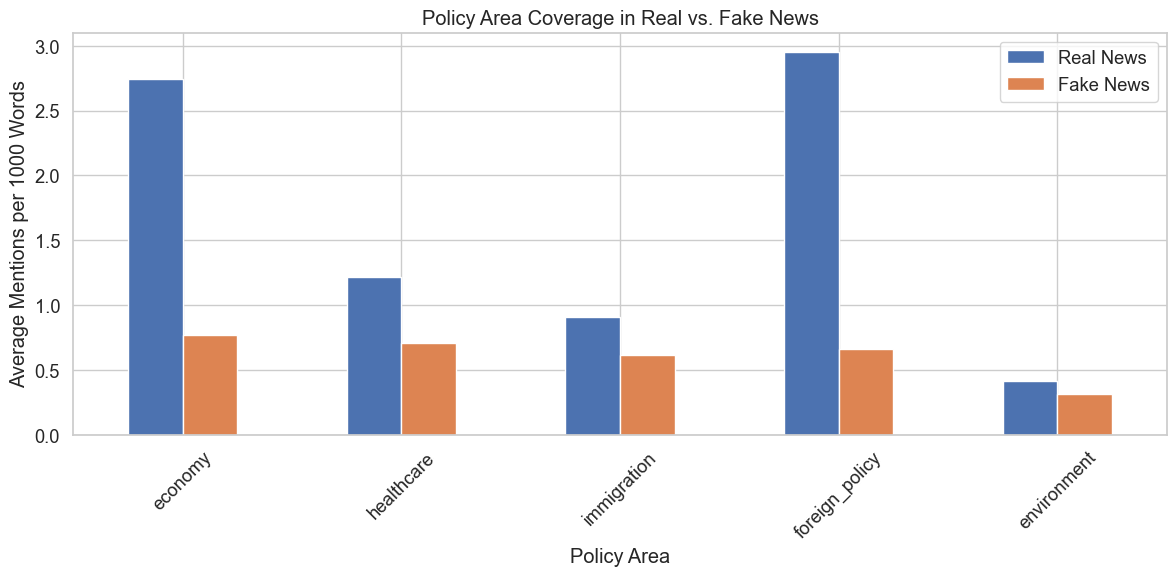

In [31]:
# Visualize policy coverage
plt.figure(figsize=(12, 6))
policy_comparison.plot(x='Policy Area', y=['Real News', 'Fake News'], kind='bar', figsize=(12, 6))
plt.title('Policy Area Coverage in Real vs. Fake News')
plt.ylabel('Average Mentions per 1000 Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./figures/policy_coverage.png')
plt.show()

The analysis shows that real news contains substantially more coverage of substantive policy areas, particularly economy (2.74 vs. 0.77), foreign policy (2.95 vs. 0.66), and healthcare (1.22 vs. 0.71).

This finding is significant for transformer models because:
1. The depth of policy discussion is a key indicator of journalistic quality
2. Models need to detect both the presence and depth of these policy discussions
3. The attention mechanism in transformers should allow them to recognize when articles focus on substantive issues versus personality-driven content

## 5. Word Choice and Vocabulary Analysis

I analyze the vocabulary differences between real and fake news:

In [32]:
# Define word cloud creation function
def create_wordcloud(text_series, title):
    """Create and save wordcloud from text series"""
    all_text = ' '.join([str(text) for text in text_series])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, contour_width=3).generate(all_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"./figures/{title.lower().replace(' ', '_')}.png")
    plt.show()

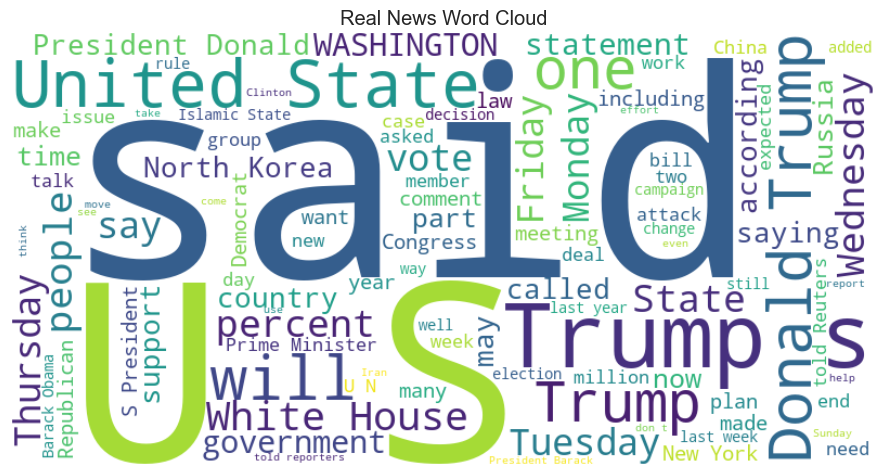

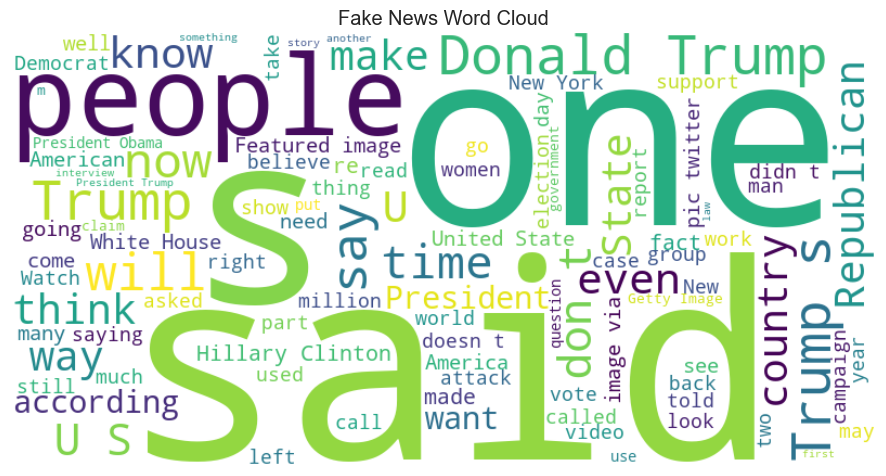

In [33]:
# Create word clouds for visual comparison
create_wordcloud(true_news['enhanced_cleaned_text'], 'Real News Word Cloud')
create_wordcloud(fake_news['enhanced_cleaned_text'], 'Fake News Word Cloud')

The word clouds provide a visual representation of the most common terms in each dataset, making it easier to identify thematic differences.

In [34]:
# Define common words extraction function
def get_common_words(texts, n=20, min_length=3):
    """Get most common words in a list of texts"""
    stop_words = set(stopwords.words('english'))
    words = []
    
    for text in texts:
        if isinstance(text, str):
            # Tokenize, convert to lowercase, remove punctuation and stopwords
            words_in_text = [word.lower().strip(string.punctuation) for word in nltk.word_tokenize(text)]
            words_in_text = [word for word in words_in_text if word not in stop_words and len(word) >= min_length and word.isalpha()]
            words.extend(words_in_text)
    
    return Counter(words).most_common(n)

In [35]:
# Get common words for both datasets
true_common_words = get_common_words(true_news['enhanced_cleaned_text'])
fake_common_words = get_common_words(fake_news['enhanced_cleaned_text'])

print("Most common words in Real News:")
print(true_common_words)

print("\nMost common words in Fake News:")
print(fake_common_words)

Most common words in Real News:
[('said', 99045), ('trump', 54322), ('would', 31528), ('president', 26456), ('state', 19760), ('government', 18323), ('new', 16786), ('states', 16628), ('house', 16548), ('also', 15953), ('united', 15576), ('republican', 15347), ('people', 15255), ('told', 14244), ('could', 13710), ('one', 12704), ('last', 12614), ('party', 12462), ('washington', 12431), ('two', 11624)]

Most common words in Fake News:
[('trump', 74287), ('said', 31156), ('people', 26024), ('president', 25800), ('would', 23461), ('one', 23014), ('clinton', 18094), ('obama', 17936), ('like', 17666), ('donald', 17244), ('also', 15246), ('news', 14211), ('new', 14201), ('even', 13700), ('hillary', 13692), ('time', 12799), ('white', 12798), ('state', 12543), ('via', 11408), ('media', 11068)]


The vocabulary analysis shows that:
1. Real news focuses more on institutional terms (government, states, party)
2. Fake news emphasizes personalities (Trump, Clinton, Obama)
3. Both mention "said" frequently, but it's much more common in real news
4. Fake news uses more informal language and includes terms like "media" and "via"

Transformer models will need to be sensitive to these content focus differences, detecting when news emphasizes personalities over substance. The contextual embeddings in transformer architectures should allow them to understand these words in their proper context.

## 6. TF-IDF Analysis of Distinctive Terms

Finally, I use TF-IDF analysis to identify the most distinctive terms in each dataset:

In [36]:
# Define TF-IDF vectorization function
def create_tfidf_vectors(true_texts, fake_texts, max_features=5000):
    """Create TF-IDF vectors for text classification"""
    # Combine texts for fitting the vectorizer
    all_texts = pd.concat([true_texts, fake_texts])
    
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=5,
        max_df=0.9,
        ngram_range=(1, 2),
        stop_words='english'
    )
    
    # Fit and transform all texts
    all_vectors = vectorizer.fit_transform(all_texts)
    
    # Split vectors back into true and fake
    true_vectors = all_vectors[:len(true_texts)]
    fake_vectors = all_vectors[len(true_texts):]
    
    return vectorizer, true_vectors, fake_vectors

In [37]:
# Create TF-IDF vectors
vectorizer, true_vectors, fake_vectors = create_tfidf_vectors(
    true_news['enhanced_cleaned_text'],
    fake_news['enhanced_cleaned_text']
)

In [38]:
# Get the top features (words/phrases) by their IDF scores
feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_
feature_idf = sorted(zip(feature_names, idf_scores), key=lambda x: x[1])

print("\nTop 10 most common terms (lowest IDF):")
for feature, score in feature_idf[:10]:
    print(f"- {feature}: {score:.4f}")

print("\nTop 10 most distinctive terms (highest IDF):")
for feature, score in feature_idf[-10:]:
    print(f"- {feature}: {score:.4f}")


Top 10 most common terms (lowest IDF):
- said: 1.3128
- president: 1.6438
- trump: 1.7077
- people: 1.8450
- donald: 1.8907
- donald trump: 1.9059
- new: 2.0455
- told: 2.0895
- just: 2.1017
- state: 2.1404

Top 10 most distinctive terms (highest IDF):
- ailes: 7.0872
- coulter: 7.0872
- zuma: 7.1478
- mnangagwa: 7.1689
- odinga: 7.1904
- conyers: 7.2578
- anc: 7.3055
- finicum: 7.5850
- 2016 realdonaldtrump: 7.6178
- amp: 8.7677


The TF-IDF analysis identifies both common terms across all articles and distinctive terms that appear in few documents. This helps us understand what features might be most informative for classification.

## 7. Implications for Transformer Model Comparison

Based on this linguistic analysis, I can draw several conclusions about what transformer models need to detect for effective fake news classification:

1. **Attribution Patterns**: Real news uses more source attribution ("said", "told") than fake news. Transformer attention mechanisms should be able to detect these patterns.

2. **Emotional Language**: Fake news uses more emotional language and emphatic punctuation. Models need to recognize when content is attempting to evoke emotional responses rather than inform.

3. **Narrative Voice**: Real news maintains an objective third-person stance, while fake news uses more first-person and second-person pronouns. This difference in voice is a reliable signal of journalistic standards.

4. **Policy Coverage**: Real news contains more substantive policy discussions across multiple domains. Models need to detect both the presence and depth of these policy discussions.

5. **Vocabulary Differences**: Real news focuses on institutional terms, while fake news emphasizes personalities. The contextual embeddings in transformer architectures should allow them to understand these words in their proper context.

These findings provide a framework for interpreting the performance of different transformer models in our comparative evaluation. Models that effectively capture these linguistic patterns should perform better at fake news detection.

## 8. Data Preparation for Model Training

Based on this analysis, I prepare the data for model training:

In [41]:
# First, check if 'enhanced_cleaned_text' exists, otherwise use 'text'
text_column = 'enhanced_cleaned_text' if 'enhanced_cleaned_text' in true_news.columns else 'text'

# Add label columns to each dataframe before concatenating
true_news['label'] = 1  # 1 for real news
fake_news['label'] = 0  # 0 for fake news

# Combine datasets for splitting
combined_df = pd.concat([
    true_news[['title', text_column, 'label']],
    fake_news[['title', text_column, 'label']]
])

# Split into train, validation, and test sets (70/15/15)
train_df, temp_df = train_test_split(combined_df, test_size=0.3, random_state=42, stratify=combined_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# Save the datasets
train_df.to_csv('./datasets/train_fake_news.csv', index=False)
val_df.to_csv('./datasets/val_fake_news.csv', index=False)
test_df.to_csv('./datasets/test_fake_news.csv', index=False)

print(f"Training set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (31428, 3)
Validation set: (6735, 3)
Test set: (6735, 3)


This data preparation process:
1. Combines the cleaned real and fake news datasets
2. Converts labels to numeric format (0 for fake, 1 for real)
3. Splits the data into training (70%), validation (15%), and test (15%) sets
4. Ensures stratification to maintain the same class distribution in all splits
5. Saves the prepared datasets for use in model training

The resulting datasets will be used in subsequent notebooks to train and evaluate different transformer models for fake news detection.

## 9. Conclusion

This analysis has provided deep insights into the linguistic patterns that distinguish real from fake news in the ISOT dataset. By identifying these patterns, we can better understand what features transformer models need to learn for effective fake news detection.

The key findings include:
1. Real news follows journalistic conventions like attribution and objective reporting
2. Fake news uses more emotional language and direct reader address
3. Real news contains more substantive policy discussions
4. Vocabulary and focus differ significantly between the two types

These insights will inform our interpretation of model performance in the comparative evaluation of lightweight pretrained transformer models. By understanding what linguistic patterns each model needs to capture, we can better assess their strengths and limitations for fake news detection.